# Setup

In [1]:
import copy
import xarray as xr
import numpy as np
import pandas as pd
from collections import OrderedDict
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors as mplc
import seaborn as sns
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
from tqdm import tqdm
import geopandas as gp
import pooch
import regionmask

# Configuration

In [54]:
#Verbose output?
verbose='true'

#Fixes masks on default ocean basin and continents masks. If you load your own, this should be turned off.
maskfixes='true'

#Choose ERA5 or NCEP2. This switch also selects the eval/???? subfolders, so do not mix and match as this 
#would lead to incorrect results.
reanalysis='ERA5'

#Define paths
obs_path='obs/'
model_path='/p/project/chhb19/streffing1/software/cmpi-tool/input/'
out_path='output/'
eval_path='eval/'+reanalysis+'/'
time = '198912-201411'

# Setup variables (turn off variables for analysis by instancing with optional argument active=False)
class variable:
    def __init__ (self, name, obs, depths, domain='mixed', active=True):
        self.name = name
        self.obs = obs
        self.depths = depths
        self.domain = domain
        self.active = active

siconc = variable(name='siconc',obs='OSISAF', depths=['surface'], domain='oce')
pr = variable(name='pr', obs='GPCP', depths=['surface'])
tas = variable(name='tas', obs=reanalysis, depths=['surface'])
clt = variable(name='clt', obs='MODIS', depths=['surface'])
rlut = variable(name='rlut', obs='CERES', depths=['surface'])
uas = variable(name='uas', obs=reanalysis, depths=['surface'])
vas = variable(name='vas', obs=reanalysis, depths=['surface'])
ua = variable(name='ua', obs=reanalysis, depths=['300hPa'])
zg = variable(name='zg', obs=reanalysis, depths=['500hPa'])
zos = variable(name='zos', obs='NESDIS', depths=['surface'])
tos = variable(name='tos', obs='HadISST2', depths=['surface'])
mlotst = variable(name='mlotst', obs='C-GLORSv7', depths=['surface'])
thetao = variable(name='thetao', obs='EN4', depths=['10m','100m','1000m'])
so = variable(name='so', obs='EN4', depths=['10m','100m','1000m'])

obs = [siconc, pr, tas, clt, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]

'''
If don't add all variables to obs for your analysis, the missing ones will be skipped.
However the variables are still present in the pre-generated .csv files. 
We still need to loop over the skipped variables to access the right lines. 
Thus we set number_of_implemented_variables manually, currently to 14.
- If you add more variables and generate new .csv files, increase the number 14 accordingly!
- If you just skip a variable for your analysis, don't change number_of_implemented_variables!
'''
number_of_implemented_variables = 14 


# Some models don't have all variables available. Thus set give each model a name and a variable dictionary
class climate_model:
    def __init__ (self, name, variables):
        self.name = name
        self.variables = variables
        
cmip6 = [
    climate_model(name='ACCESS-CM2',   variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='AWI-CM1-MR',   variables=[        tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='BCC-SM2-MR',   variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CAMS',         variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CanESM5',      variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CAS-ESM2-0',   variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos,                   ]),
    climate_model(name='CESM2',        variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos, mlotst            ]),
    climate_model(name='CIESM',        variables=[        tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
    climate_model(name='CMCC-CM2-SR5', variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='CNRM-CM6-1-HR',variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst            ]),
    climate_model(name='E3SM-1-1',     variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='EC-Earth3',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='FGOALS-f3-L',  variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='FIO-ESM-2-0',  variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
    climate_model(name='GISS-E2-1-G',  variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='HadGEM3MM',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='ICON-ESM-LR',  variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='IITM-ESM',     variables=[        tas, clt, pr, rlut, uas, vas, ua, zg,      tos,                   ]),
    climate_model(name='INM5',         variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg,                   thetao, so]),
    climate_model(name='IPSL-CM6A-LR', variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='KIOST-ESM',    variables=[siconc, tas, clt,     rlut, uas, vas, ua, zg, zos, tos, mlotst,           ]),
    climate_model(name='MCMUA1',       variables=[        tas,        pr, rlut, uas, vas, ua, zg,    tos,         thetao, so]),
    climate_model(name='MIROC6',       variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos,                   ]),
    climate_model(name='MPI-ESM1-2-HR',variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='MRI-ESM2-0',   variables=[siconc, tas, clt, pr, rlut, uas, vas,         zos, tos, mlotst, thetao, so]),
    climate_model(name='NESM3',        variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),   
    climate_model(name='NOAA-GFDL',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos,         thetao, so]),
    climate_model(name='NorESM2-MM',   variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos, mlotst, thetao, so]),
    climate_model(name='SNU',          variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
    climate_model(name='TaiESM1',      variables=[siconc, tas, clt, pr, rlut,           ua, zg, zos, tos,         thetao, so]),
]

ece3= [    
    climate_model(name='EC-Earth3',    variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
]

awi_cm3_v31= [
    climate_model(name='AWI-CM3-v3.1', variables=[siconc, tas, clt, pr, rlut, uas, vas, ua, zg, zos, tos, mlotst, thetao, so]),
]
                  
models = cmip6

eval_models = cmip6


#Select regions 
class region:
    def __init__ (self, name, domain, active=False):
        self.name = name
        self.domain = domain
        self.active = active
        
glob = region(name='glob', domain='mixed')
arctic =  region(name='arctic', domain='mixed')
Atlantic_Basin =  region(name='Atlantic_Basin', domain='ocean')
Asia =  region(name='Asia', domain='land')

complexity = 'all'

if complexity == 'boxes':
    regions_select = ['glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 'southmid', 'antarctic']
elif complexity == 'regions':
    regions_select = ['Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Arctic_Basin', 'Southern_Ocean_Basin', 
                      'Mediterranean_Basin', 'Asia', 'North_America', 'Europe', 'Africa', 'South_America', 
                      'Oceania', 'Australia', 'Antarctica']
else:
    regions_select = ['Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Arctic_Basin', 'Southern_Ocean_Basin', 
                      'Mediterranean_Basin', 'Asia', 'North_America', 'Europe', 'Africa', 'South_America', 'Oceania', 
                      'Australia', 'Antarctica','glob', 'arctic', 'northmid', 'tropics', 'innertropics', 'nino34', 
                      'southmid', 'antarctic']

        
#Select seasons
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# Dataloading

In [55]:
# Retrieve Polygons; Read them; Interpolate to 2° x 2° masks; Concat into one DataArray 
file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gp.read_file("zip://" + file)
ocean_basins = gp.read_file("geojson/ocean_basins.geojson")

lon = np.arange(0, 360, 2)
lat = np.arange(-90, 90, 2)
continents_masks = regionmask.mask_3D_geopandas(continents, lon, lat)
ocean_basins_masks = regionmask.mask_3D_geopandas(ocean_basins, lon, lat)

ocean_basins_masks['region'==1]
ocean_basins_masks['region']=ocean_basins_masks.region+continents_masks.sizes['region']


In [56]:
# Add simple box masks

#Define regions
boxes={
    'glob' : {
    'lat_min':-90,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'none',},
         
    'arctic' : {
    'lat_min':60,
    'lat_max':90,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'red',},
         
    'northmid' : {
    'lat_min':30,
    'lat_max':60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'lightgrey',},
         
    'tropics' : {
    'lat_min':-30,
    'lat_max':30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
         
    'innertropics' : {
    'lat_min':-15,
    'lat_max':15,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'green',},
        
    'nino34' : {
    'lat_min':-5,
    'lat_max':5,
    'lon_min':190,
    'lon_max':240,
    'plot_color':'yellow',},
         
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
         
    'antarctic' : {
    'lat_min':-90,
    'lat_max':-60,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'blue',},
    
    'southmid' : {
    'lat_min':-60,
    'lat_max':-30,
    'lon_min':0,
    'lon_max':360,
    'plot_color':'pink',},
          
}

# Create lat & lon filters based on box edges
boxlist=[]
for box in boxes:
    boxlist.append(box)
    
boxnum=[]
mask_lat=OrderedDict()
mask_lat=OrderedDict()
n=0
box_masks_np=np.empty(shape=(len(lat),len(lon),len(boxlist)))
for box in boxes:
    mask_lat=np.logical_and(lat>boxes[box]['lat_min'], lat<boxes[box]['lat_max'])
    mask_lon=np.logical_and(lon>boxes[box]['lon_min'], lon<boxes[box]['lon_max'])
    boxnum.append(n+ocean_basins_masks.sizes['region']+continents_masks.sizes['region']) # offset region number 

    
    # Make numpy array with gridded mask
    for i in range(0,len(lat)):
        for j in range(0,len(lon)):
            box_masks_np[i,j,n]=np.logical_and(mask_lat[i],mask_lon[j])
    n+=1     
    
# Same xarray format as complex ocean and continent masks above.
box_masks = xr.DataArray(box_masks_np, 
coords={'lat': lat,'lon': lon,'region': boxnum}, 
dims=["lat", "lon", "region"])


In [57]:
masks=xr.concat((continents_masks,ocean_basins_masks,box_masks),dim="region")

if maskfixes:
    # Create Southern Ocean mask via xor nearby continental masks 
    save_orig = copy.deepcopy(masks.sel(region=12))
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=4)) #South America
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=5)) #Oceania
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=6)) #Australia
    masks[12,:,:] = np.logical_xor(masks.sel(region=12), masks.sel(region=7)) #Antarctica
    masks[12,:,:] = np.logical_and(masks.sel(region=12), save_orig)

    # Fix the Arctic and Atlantic bleeding into Greenland
    save_orig = copy.deepcopy(masks.sel(region=8))
    masks[8,:,:] = np.logical_xor(masks.sel(region=8), masks.sel(region=1)) 
    masks[8,:,:] = np.logical_and(masks.sel(region=8), save_orig) 


In [58]:
# Store masks as dictrionary for easy access
regions_avail = OrderedDict()


for i in range(0,continents_masks.sizes['region']):
    if verbose:
        print('Mask available for:',i,continents['CONTINENT'][i].replace(' ', '_'))
    regions_avail[continents['CONTINENT'][i].replace(' ', '_')]={ 
        'mask': masks[i]
    }
for i in range(0,ocean_basins_masks.sizes['region']):
    if verbose:
        print('Mask available for:',i,ocean_basins['name'][i].replace(' ', '_'))
    regions_avail[ocean_basins['name'][i].replace(' ', '_')]={ 
        'mask': masks[i+continents_masks.sizes['region']]
    }
for i in range(boxnum[0],boxnum[len(boxnum)-1]+1):
    if verbose:
        print('Mask available for:',i,boxlist[i-boxnum[0]].replace(' ', '_'))
    regions_avail[boxlist[i-boxnum[0]].replace(' ', '_')]={ 
        'mask': masks[i]
    }
    

# Select subset of available regions
regions = OrderedDict()
for r in regions_select:
    if verbose:
        print('Selecting Mask for:',r)
    regions[r] = regions_avail[r]

Mask available for: 0 Asia
Mask available for: 1 North_America
Mask available for: 2 Europe
Mask available for: 3 Africa
Mask available for: 4 South_America
Mask available for: 5 Oceania
Mask available for: 6 Australia
Mask available for: 7 Antarctica
Mask available for: 0 Atlantic_Basin
Mask available for: 1 Pacific_Basin
Mask available for: 2 Indian_Basin
Mask available for: 3 Arctic_Basin
Mask available for: 4 Southern_Ocean_Basin
Mask available for: 5 Mediterranean_Basin
Mask available for: 14 glob
Mask available for: 15 arctic
Mask available for: 16 northmid
Mask available for: 17 tropics
Mask available for: 18 innertropics
Mask available for: 19 nino34
Mask available for: 20 southmid
Mask available for: 21 antarctic
Selecting Mask for: Atlantic_Basin
Selecting Mask for: Pacific_Basin
Selecting Mask for: Indian_Basin
Selecting Mask for: Arctic_Basin
Selecting Mask for: Southern_Ocean_Basin
Selecting Mask for: Mediterranean_Basin
Selecting Mask for: Asia
Selecting Mask for: North_A

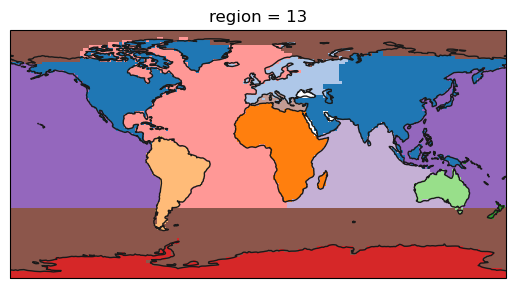

In [59]:
cm = plt.get_cmap('tab20')
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
for i in range(0,ocean_basins_masks.sizes['region']+continents_masks.sizes['region']):
    cmap = mplc.ListedColormap(['#FFFFFF00', cm(1*i/masks.sizes['region'])])
    masks.sel(region=i).plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        add_colorbar=False,
        cmap=cmap,
    )

ax.coastlines(color="0.1");

In [60]:
print('Loading obs data')

ds_obs = OrderedDict()

for var in obs:
    for depth in var.depths:
        for seas in seasons:
            if verbose == 'true':
                print('loading '+obs_path+var.name+'_'+var.obs+'_'+depth+'_'+seas+'.nc')

            intermediate = xr.open_dataset(obs_path+var.name+'_'+var.obs+'_'+depth+'_'+seas+'.nc')
            ds_obs[var.name,depth,seas] = intermediate.compute()
            try:
                ds_obs[var.name,depth,seas]=ds_obs[var.name,depth,seas].drop('time_bnds')
            except:
                pass
            try:
                ds_obs[var.name,depth,seas]=ds_obs[var.name,depth,seas].drop('time_bnds_2')
            except:
                pass
            try:
                ds_obs[var.name,depth,seas]=ds_obs[var.name,depth,seas].drop('depth')
            except:
                pass
            

Loading obs data
loading obs/siconc_OSISAF_surface_MAM.nc
loading obs/siconc_OSISAF_surface_JJA.nc
loading obs/siconc_OSISAF_surface_SON.nc
loading obs/siconc_OSISAF_surface_DJF.nc
loading obs/pr_GPCP_surface_MAM.nc
loading obs/pr_GPCP_surface_JJA.nc
loading obs/pr_GPCP_surface_SON.nc
loading obs/pr_GPCP_surface_DJF.nc
loading obs/tas_ERA5_surface_MAM.nc
loading obs/tas_ERA5_surface_JJA.nc
loading obs/tas_ERA5_surface_SON.nc
loading obs/tas_ERA5_surface_DJF.nc
loading obs/clt_MODIS_surface_MAM.nc
loading obs/clt_MODIS_surface_JJA.nc
loading obs/clt_MODIS_surface_SON.nc
loading obs/clt_MODIS_surface_DJF.nc
loading obs/rlut_CERES_surface_MAM.nc
loading obs/rlut_CERES_surface_JJA.nc
loading obs/rlut_CERES_surface_SON.nc
loading obs/rlut_CERES_surface_DJF.nc
loading obs/uas_ERA5_surface_MAM.nc
loading obs/uas_ERA5_surface_JJA.nc
loading obs/uas_ERA5_surface_SON.nc
loading obs/uas_ERA5_surface_DJF.nc
loading obs/vas_ERA5_surface_MAM.nc
loading obs/vas_ERA5_surface_JJA.nc
loading obs/vas_ERA

In [61]:
print('Loading model data')

ds_model = OrderedDict()

for model in tqdm(models):
    for var in model.variables:
        for depth in var.depths:
            for seas in seasons:
                if verbose == 'true':
                    print('loading '+model_path+var.name+'_'+model.name+'_'+time+'_'+depth+'_'+seas+'.nc')
                intermediate = xr.open_mfdataset(model_path+var.name+'_'+model.name+'_'+time+'_'+depth+'_'+seas+'.nc')
                intermediate = intermediate.squeeze(drop=True)
                ds_model[var.name,depth,seas,model.name] = intermediate.compute()
                try:
                    ds_model[var.name,depth,seas,model.name]=ds_model[var.name,depth,seas,model.name].drop('time_bnds')
                except:
                    pass
                try:
                    ds_model[var.name,depth,seas,model.name]=ds_model[var.name,depth,seas,model.name].drop('depth')
                except:
                    pass


Loading model data


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ACCESS-CM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ACCESS-CM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_ACCESS-CM2_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffin

  3%|█████▊                                                                                                                                                                         | 1/30 [00:03<01:42,  3.52s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ACCESS-CM2_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM1-MR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM1-MR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM1-MR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_AWI-CM1-MR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_AWI-CM1-MR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_AWI-CM1-MR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool

  7%|███████████▋                                                                                                                                                                   | 2/30 [00:07<01:38,  3.52s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_AWI-CM1-MR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_BCC-SM2-MR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_BCC-SM2-MR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_BCC-SM2-MR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_BCC-SM2-MR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_BCC-SM2-MR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_BCC-SM2-MR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_BCC-SM2-MR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_BCC-SM2-MR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/

 10%|█████████████████▌                                                                                                                                                             | 3/30 [00:07<01:03,  2.34s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_BCC-SM2-MR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_BCC-SM2-MR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_BCC-SM2-MR_

 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:08<00:46,  1.79s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CAMS_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CAMS_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CAMS_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CAMS_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CAMS_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CanESM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CanESM5_198912-201411_surf

 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:11<00:55,  2.21s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CanESM5_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CAS-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CAS-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CAS-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CAS-ESM2-0_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CAS-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CAS-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CAS-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/

 20%|███████████████████████████████████                                                                                                                                            | 6/30 [00:12<00:39,  1.63s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_CAS-ESM2-0_198912-201411_500hPa_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_CAS-ESM2-0_198912-201411_500hPa_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_CAS-ESM2-0_198912-201411_500hPa_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zg_CAS-ESM2-0_198912-201411_500hPa_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/zos_CAS-ESM2-0_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_CAS-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-too

 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:14<00:40,  1.75s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CESM2_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CESM2_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CIESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_CIESM_198912-201411

 27%|██████████████████████████████████████████████▋                                                                                                                                | 8/30 [00:17<00:46,  2.12s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CIESM_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CMCC-CM2-SR5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CMCC-CM2-SR5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CMCC-CM2-SR5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CMCC-CM2-SR5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CMCC-CM2-SR5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CMCC-CM2-SR5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CMCC-CM2-SR5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CMCC-CM2-SR5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/

 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:21<00:55,  2.66s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_CMCC-CM2-SR5_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_CNRM-CM6-1-HR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CNRM-CM6-1-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CNRM-CM6-1-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_CNRM-CM6-1-HR_198912-201411_surface_SON.nc
loading /p/proj

 33%|██████████████████████████████████████████████████████████                                                                                                                    | 10/30 [00:23<00:50,  2.53s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_CNRM-CM6-1-HR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_E3SM-1-1_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_E3SM-1-1_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_E3SM-1-1_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_E3SM-1-1_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_E3SM-1-1_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_E3SM-1-1_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_E3SM-1-1_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_E3SM-1-1_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/softwar

 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:26<00:50,  2.68s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_E3SM-1-1_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_E3SM-1-1_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_EC-Earth3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_EC-Earth3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 12/30 [00:29<00:49,  2.77s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_EC-Earth3_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FGOALS-f3-L_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FGOALS-f3-L_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FGOALS-f3-L_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/sof

 43%|███████████████████████████████████████████████████████████████████████████▍                                                                                                  | 13/30 [00:30<00:37,  2.21s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FGOALS-f3-L_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FIO-ESM-2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FIO-ESM-2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FIO-ESM-2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_FIO-ESM-2-0_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_FIO-ESM-2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/

 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 14/30 [00:33<00:39,  2.48s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_FIO-ESM-2-0_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_GISS-E2-1-G_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_GISS-E2-1-G_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_GISS-E2-1-G_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_GISS-E2-1-G_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_GISS-E2-1-G_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_GISS-E2-1-G_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffin

 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 15/30 [00:34<00:30,  2.03s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_GISS-E2-1-G_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_HadGEM3MM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_HadGEM3MM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_HadGEM3MM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-too

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:38<00:35,  2.54s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_HadGEM3MM_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ICON-ESM-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ICON-ESM-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ICON-ESM-LR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_ICON-ESM-LR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ICON-ESM-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_ICON-ESM-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/sof

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 17/30 [00:41<00:36,  2.79s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_ICON-ESM-LR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IITM-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IITM-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IITM-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IITM-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_IITM-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_IITM-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/cl

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18/30 [00:43<00:29,  2.47s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_INM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_INM5_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_INM5_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_INM5_198912-201411_sur

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19/30 [00:46<00:28,  2.60s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_INM5_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_INM5_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_INM5_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_IPSL-CM6A-LR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IPSL-CM6A-LR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_IPSL-CM6A-LR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmp

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 20/30 [00:49<00:27,  2.78s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/softwa

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 21/30 [00:49<00:18,  2.11s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/mlotst_KIOST-ESM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MCMUA1_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:50<00:13,  1.67s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/thetao_MCMUA1_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_10m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_100m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MCMUA1_198912-201411_1000m_MAM.nc
loading /p/project

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 23/30 [00:52<00:12,  1.85s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tos_MIROC6_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MPI-ESM1-2-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MPI-ESM1-2-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MPI-ESM1-2-HR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MPI-ESM1-2-HR_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MPI-ESM1-2-HR_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MPI-ESM1-2-HR_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MPI-ESM1-2-HR_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MPI-ESM1-2-HR_198912-201411_surface_DJF.nc
loading /p/pro

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 24/30 [00:56<00:14,  2.42s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MPI-ESM1-2-HR_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MRI-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MRI-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MRI-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_MRI-ESM2-0_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MRI-ESM2-0_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MRI-ESM2-0_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_MRI-ESM2-0_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffin

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 25/30 [00:59<00:13,  2.70s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MRI-ESM2-0_198912-201411_1000m_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MRI-ESM2-0_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_MRI-ESM2-0_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NESM3_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NESM3_1

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26/30 [01:03<00:11,  3.00s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NOAA-GFDL_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NOAA-GFDL_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_NOAA-GFDL_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/softwa

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 27/30 [01:07<00:09,  3.22s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NorESM2-MM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NorESM2-MM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NorESM2-MM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_NorESM2-MM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NorESM2-MM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NorESM2-MM_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NorESM2-MM_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_NorESM2-MM_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_NorESM2-MM_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffin

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [01:10<00:06,  3.24s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_1000m_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_NorESM2-MM_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_SNU_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_SNU_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_SNU_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_SNU_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_SNU_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_SNU_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_SNU_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_SNU_198912-201411_surfa

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 29/30 [01:13<00:03,  3.13s/it]

loading /p/project/chhb19/streffing1/software/cmpi-tool/input/so_SNU_198912-201411_1000m_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_TaiESM1_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_TaiESM1_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_TaiESM1_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/siconc_TaiESM1_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_TaiESM1_198912-201411_surface_MAM.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_TaiESM1_198912-201411_surface_JJA.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_TaiESM1_198912-201411_surface_SON.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/tas_TaiESM1_198912-201411_surface_DJF.nc
loading /p/project/chhb19/streffing1/software/cmpi-tool/input/clt_Ta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:16<00:00,  2.55s/it]


# CMIP calcluations

In [62]:
print('Calculating absolute error and field mean of abs error')

# Returns equvalent to cdo fldmean ()
def fldmean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    return ds.mean(("lon", "lat"))


abs_error = OrderedDict()
mean_error = OrderedDict()

for model in tqdm(models):
    for var in model.variables:
        for depth in var.depths:
            for region in regions:
                for seas in seasons:
                    abs_error[var.name,depth,seas,model.name,region]=np.sqrt((ds_model[var.name,depth,seas,model.name].where(regions[region]['mask'])-
                                                       ds_obs[var.name,depth,seas]).where(regions[region]['mask'])*
                                                      (ds_model[var.name,depth,seas,model.name].where(regions[region]['mask'])-
                                                       ds_obs[var.name,depth,seas].where(regions[region]['mask'])))
                    mean_error[var.name,depth,seas,model.name,region] = fldmean(abs_error[var.name,depth,seas,model.name,region])


Calculating absolute error and field mean of abs error


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [05:18<00:00, 10.60s/it]


In [63]:
print('Writing field mean of errors into csv files')

for model in tqdm(models):
    with open(out_path+'abs/'+model.name+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','AbsMeanError'])
        for var in model.variables:
            for depth in var.depths:
                for region in regions:
                    for seas in seasons:
                        print(seas, depth, region, var.name, model.name)
                        writer.writerow([var.name,region,depth,seas,np.squeeze(mean_error[var.name,depth,seas,model.name,region].to_array(var.name).values[0])])

Writing field mean of errors into csv files


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

MAM surface Atlantic_Basin siconc ACCESS-CM2
JJA surface Atlantic_Basin siconc ACCESS-CM2
SON surface Atlantic_Basin siconc ACCESS-CM2
DJF surface Atlantic_Basin siconc ACCESS-CM2
MAM surface Pacific_Basin siconc ACCESS-CM2
JJA surface Pacific_Basin siconc ACCESS-CM2
SON surface Pacific_Basin siconc ACCESS-CM2
DJF surface Pacific_Basin siconc ACCESS-CM2
MAM surface Indian_Basin siconc ACCESS-CM2
JJA surface Indian_Basin siconc ACCESS-CM2
SON surface Indian_Basin siconc ACCESS-CM2
DJF surface Indian_Basin siconc ACCESS-CM2
MAM surface Arctic_Basin siconc ACCESS-CM2
JJA surface Arctic_Basin siconc ACCESS-CM2
SON surface Arctic_Basin siconc ACCESS-CM2
DJF surface Arctic_Basin siconc ACCESS-CM2
MAM surface Southern_Ocean_Basin siconc ACCESS-CM2
JJA surface Southern_Ocean_Basin siconc ACCESS-CM2
SON surface Southern_Ocean_Basin siconc ACCESS-CM2
DJF surface Southern_Ocean_Basin siconc ACCESS-CM2
MAM surface Mediterranean_Basin siconc ACCESS-CM2
JJA surface Mediterranean_Basin siconc ACCESS-

  3%|█████▊                                                                                                                                                                         | 1/30 [00:00<00:16,  1.81it/s]

SON 10m Antarctica thetao ACCESS-CM2
DJF 10m Antarctica thetao ACCESS-CM2
MAM 10m glob thetao ACCESS-CM2
JJA 10m glob thetao ACCESS-CM2
SON 10m glob thetao ACCESS-CM2
DJF 10m glob thetao ACCESS-CM2
MAM 10m arctic thetao ACCESS-CM2
JJA 10m arctic thetao ACCESS-CM2
SON 10m arctic thetao ACCESS-CM2
DJF 10m arctic thetao ACCESS-CM2
MAM 10m northmid thetao ACCESS-CM2
JJA 10m northmid thetao ACCESS-CM2
SON 10m northmid thetao ACCESS-CM2
DJF 10m northmid thetao ACCESS-CM2
MAM 10m tropics thetao ACCESS-CM2
JJA 10m tropics thetao ACCESS-CM2
SON 10m tropics thetao ACCESS-CM2
DJF 10m tropics thetao ACCESS-CM2
MAM 10m innertropics thetao ACCESS-CM2
JJA 10m innertropics thetao ACCESS-CM2
SON 10m innertropics thetao ACCESS-CM2
DJF 10m innertropics thetao ACCESS-CM2
MAM 10m nino34 thetao ACCESS-CM2
JJA 10m nino34 thetao ACCESS-CM2
SON 10m nino34 thetao ACCESS-CM2
DJF 10m nino34 thetao ACCESS-CM2
MAM 10m southmid thetao ACCESS-CM2
JJA 10m southmid thetao ACCESS-CM2
SON 10m southmid thetao ACCESS-CM2
D

  7%|███████████▋                                                                                                                                                                   | 2/30 [00:01<00:14,  1.88it/s]

MAM surface Atlantic_Basin siconc BCC-SM2-MR
JJA surface Atlantic_Basin siconc BCC-SM2-MR
SON surface Atlantic_Basin siconc BCC-SM2-MR
DJF surface Atlantic_Basin siconc BCC-SM2-MR
MAM surface Pacific_Basin siconc BCC-SM2-MR
JJA surface Pacific_Basin siconc BCC-SM2-MR
SON surface Pacific_Basin siconc BCC-SM2-MR
DJF surface Pacific_Basin siconc BCC-SM2-MR
MAM surface Indian_Basin siconc BCC-SM2-MR
JJA surface Indian_Basin siconc BCC-SM2-MR
SON surface Indian_Basin siconc BCC-SM2-MR
DJF surface Indian_Basin siconc BCC-SM2-MR
MAM surface Arctic_Basin siconc BCC-SM2-MR
JJA surface Arctic_Basin siconc BCC-SM2-MR
SON surface Arctic_Basin siconc BCC-SM2-MR
DJF surface Arctic_Basin siconc BCC-SM2-MR
MAM surface Southern_Ocean_Basin siconc BCC-SM2-MR
JJA surface Southern_Ocean_Basin siconc BCC-SM2-MR
SON surface Southern_Ocean_Basin siconc BCC-SM2-MR
DJF surface Southern_Ocean_Basin siconc BCC-SM2-MR
MAM surface Mediterranean_Basin siconc BCC-SM2-MR
JJA surface Mediterranean_Basin siconc BCC-SM2

SON surface tropics vas BCC-SM2-MR
DJF surface tropics vas BCC-SM2-MR
MAM surface innertropics vas BCC-SM2-MR
JJA surface innertropics vas BCC-SM2-MR
SON surface innertropics vas BCC-SM2-MR
DJF surface innertropics vas BCC-SM2-MR
MAM surface nino34 vas BCC-SM2-MR
JJA surface nino34 vas BCC-SM2-MR
SON surface nino34 vas BCC-SM2-MR
DJF surface nino34 vas BCC-SM2-MR
MAM surface southmid vas BCC-SM2-MR
JJA surface southmid vas BCC-SM2-MR
SON surface southmid vas BCC-SM2-MR
DJF surface southmid vas BCC-SM2-MR
MAM surface antarctic vas BCC-SM2-MR
JJA surface antarctic vas BCC-SM2-MR
SON surface antarctic vas BCC-SM2-MR
DJF surface antarctic vas BCC-SM2-MR
MAM 300hPa Atlantic_Basin ua BCC-SM2-MR
JJA 300hPa Atlantic_Basin ua BCC-SM2-MR
SON 300hPa Atlantic_Basin ua BCC-SM2-MR
DJF 300hPa Atlantic_Basin ua BCC-SM2-MR
MAM 300hPa Pacific_Basin ua BCC-SM2-MR
JJA 300hPa Pacific_Basin ua BCC-SM2-MR
SON 300hPa Pacific_Basin ua BCC-SM2-MR
DJF 300hPa Pacific_Basin ua BCC-SM2-MR
MAM 300hPa Indian_Basin ua

 13%|███████████████████████▎                                                                                                                                                       | 4/30 [00:02<00:13,  1.86it/s]

MAM surface Atlantic_Basin siconc CAMS
JJA surface Atlantic_Basin siconc CAMS
SON surface Atlantic_Basin siconc CAMS
DJF surface Atlantic_Basin siconc CAMS
MAM surface Pacific_Basin siconc CAMS
JJA surface Pacific_Basin siconc CAMS
SON surface Pacific_Basin siconc CAMS
DJF surface Pacific_Basin siconc CAMS
MAM surface Indian_Basin siconc CAMS
JJA surface Indian_Basin siconc CAMS
SON surface Indian_Basin siconc CAMS
DJF surface Indian_Basin siconc CAMS
MAM surface Arctic_Basin siconc CAMS
JJA surface Arctic_Basin siconc CAMS
SON surface Arctic_Basin siconc CAMS
DJF surface Arctic_Basin siconc CAMS
MAM surface Southern_Ocean_Basin siconc CAMS
JJA surface Southern_Ocean_Basin siconc CAMS
SON surface Southern_Ocean_Basin siconc CAMS
DJF surface Southern_Ocean_Basin siconc CAMS
MAM surface Mediterranean_Basin siconc CAMS
JJA surface Mediterranean_Basin siconc CAMS
SON surface Mediterranean_Basin siconc CAMS
DJF surface Mediterranean_Basin siconc CAMS
MAM surface Asia siconc CAMS
JJA surface

 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:02<00:13,  1.85it/s]

JJA 1000m Southern_Ocean_Basin so CanESM5
SON 1000m Southern_Ocean_Basin so CanESM5
DJF 1000m Southern_Ocean_Basin so CanESM5
MAM 1000m Mediterranean_Basin so CanESM5
JJA 1000m Mediterranean_Basin so CanESM5
SON 1000m Mediterranean_Basin so CanESM5
DJF 1000m Mediterranean_Basin so CanESM5
MAM 1000m Asia so CanESM5
JJA 1000m Asia so CanESM5
SON 1000m Asia so CanESM5
DJF 1000m Asia so CanESM5
MAM 1000m North_America so CanESM5
JJA 1000m North_America so CanESM5
SON 1000m North_America so CanESM5
DJF 1000m North_America so CanESM5
MAM 1000m Europe so CanESM5
JJA 1000m Europe so CanESM5
SON 1000m Europe so CanESM5
DJF 1000m Europe so CanESM5
MAM 1000m Africa so CanESM5
JJA 1000m Africa so CanESM5
SON 1000m Africa so CanESM5
DJF 1000m Africa so CanESM5
MAM 1000m South_America so CanESM5
JJA 1000m South_America so CanESM5
SON 1000m South_America so CanESM5
DJF 1000m South_America so CanESM5
MAM 1000m Oceania so CanESM5
JJA 1000m Oceania so CanESM5
SON 1000m Oceania so CanESM5
DJF 1000m Ocean

 23%|████████████████████████████████████████▊                                                                                                                                      | 7/30 [00:03<00:09,  2.42it/s]

MAM surface Atlantic_Basin siconc CESM2
JJA surface Atlantic_Basin siconc CESM2
SON surface Atlantic_Basin siconc CESM2
DJF surface Atlantic_Basin siconc CESM2
MAM surface Pacific_Basin siconc CESM2
JJA surface Pacific_Basin siconc CESM2
SON surface Pacific_Basin siconc CESM2
DJF surface Pacific_Basin siconc CESM2
MAM surface Indian_Basin siconc CESM2
JJA surface Indian_Basin siconc CESM2
SON surface Indian_Basin siconc CESM2
DJF surface Indian_Basin siconc CESM2
MAM surface Arctic_Basin siconc CESM2
JJA surface Arctic_Basin siconc CESM2
SON surface Arctic_Basin siconc CESM2
DJF surface Arctic_Basin siconc CESM2
MAM surface Southern_Ocean_Basin siconc CESM2
JJA surface Southern_Ocean_Basin siconc CESM2
SON surface Southern_Ocean_Basin siconc CESM2
DJF surface Southern_Ocean_Basin siconc CESM2
MAM surface Mediterranean_Basin siconc CESM2
JJA surface Mediterranean_Basin siconc CESM2
SON surface Mediterranean_Basin siconc CESM2
DJF surface Mediterranean_Basin siconc CESM2
MAM surface Asia

 30%|████████████████████████████████████████████████████▌                                                                                                                          | 9/30 [00:04<00:09,  2.22it/s]

MAM surface Atlantic_Basin siconc CMCC-CM2-SR5
JJA surface Atlantic_Basin siconc CMCC-CM2-SR5
SON surface Atlantic_Basin siconc CMCC-CM2-SR5
DJF surface Atlantic_Basin siconc CMCC-CM2-SR5
MAM surface Pacific_Basin siconc CMCC-CM2-SR5
JJA surface Pacific_Basin siconc CMCC-CM2-SR5
SON surface Pacific_Basin siconc CMCC-CM2-SR5
DJF surface Pacific_Basin siconc CMCC-CM2-SR5
MAM surface Indian_Basin siconc CMCC-CM2-SR5
JJA surface Indian_Basin siconc CMCC-CM2-SR5
SON surface Indian_Basin siconc CMCC-CM2-SR5
DJF surface Indian_Basin siconc CMCC-CM2-SR5
MAM surface Arctic_Basin siconc CMCC-CM2-SR5
JJA surface Arctic_Basin siconc CMCC-CM2-SR5
SON surface Arctic_Basin siconc CMCC-CM2-SR5
DJF surface Arctic_Basin siconc CMCC-CM2-SR5
MAM surface Southern_Ocean_Basin siconc CMCC-CM2-SR5
JJA surface Southern_Ocean_Basin siconc CMCC-CM2-SR5
SON surface Southern_Ocean_Basin siconc CMCC-CM2-SR5
DJF surface Southern_Ocean_Basin siconc CMCC-CM2-SR5
MAM surface Mediterranean_Basin siconc CMCC-CM2-SR5
JJA 

 37%|███████████████████████████████████████████████████████████████▊                                                                                                              | 11/30 [00:05<00:08,  2.27it/s]

MAM surface Atlantic_Basin siconc E3SM-1-1
JJA surface Atlantic_Basin siconc E3SM-1-1
SON surface Atlantic_Basin siconc E3SM-1-1
DJF surface Atlantic_Basin siconc E3SM-1-1
MAM surface Pacific_Basin siconc E3SM-1-1
JJA surface Pacific_Basin siconc E3SM-1-1
SON surface Pacific_Basin siconc E3SM-1-1
DJF surface Pacific_Basin siconc E3SM-1-1
MAM surface Indian_Basin siconc E3SM-1-1
JJA surface Indian_Basin siconc E3SM-1-1
SON surface Indian_Basin siconc E3SM-1-1
DJF surface Indian_Basin siconc E3SM-1-1
MAM surface Arctic_Basin siconc E3SM-1-1
JJA surface Arctic_Basin siconc E3SM-1-1
SON surface Arctic_Basin siconc E3SM-1-1
DJF surface Arctic_Basin siconc E3SM-1-1
MAM surface Southern_Ocean_Basin siconc E3SM-1-1
JJA surface Southern_Ocean_Basin siconc E3SM-1-1
SON surface Southern_Ocean_Basin siconc E3SM-1-1
DJF surface Southern_Ocean_Basin siconc E3SM-1-1
MAM surface Mediterranean_Basin siconc E3SM-1-1
JJA surface Mediterranean_Basin siconc E3SM-1-1
SON surface Mediterranean_Basin siconc E

 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 12/30 [00:05<00:08,  2.11it/s]

MAM surface Atlantic_Basin siconc FGOALS-f3-L
JJA surface Atlantic_Basin siconc FGOALS-f3-L
SON surface Atlantic_Basin siconc FGOALS-f3-L
DJF surface Atlantic_Basin siconc FGOALS-f3-L
MAM surface Pacific_Basin siconc FGOALS-f3-L
JJA surface Pacific_Basin siconc FGOALS-f3-L
SON surface Pacific_Basin siconc FGOALS-f3-L
DJF surface Pacific_Basin siconc FGOALS-f3-L
MAM surface Indian_Basin siconc FGOALS-f3-L
JJA surface Indian_Basin siconc FGOALS-f3-L
SON surface Indian_Basin siconc FGOALS-f3-L
DJF surface Indian_Basin siconc FGOALS-f3-L
MAM surface Arctic_Basin siconc FGOALS-f3-L
JJA surface Arctic_Basin siconc FGOALS-f3-L
SON surface Arctic_Basin siconc FGOALS-f3-L
DJF surface Arctic_Basin siconc FGOALS-f3-L
MAM surface Southern_Ocean_Basin siconc FGOALS-f3-L
JJA surface Southern_Ocean_Basin siconc FGOALS-f3-L
SON surface Southern_Ocean_Basin siconc FGOALS-f3-L
DJF surface Southern_Ocean_Basin siconc FGOALS-f3-L
MAM surface Mediterranean_Basin siconc FGOALS-f3-L
JJA surface Mediterranean

 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 14/30 [00:06<00:07,  2.07it/s]

MAM surface Atlantic_Basin siconc FIO-ESM-2-0
JJA surface Atlantic_Basin siconc FIO-ESM-2-0
SON surface Atlantic_Basin siconc FIO-ESM-2-0
DJF surface Atlantic_Basin siconc FIO-ESM-2-0
MAM surface Pacific_Basin siconc FIO-ESM-2-0
JJA surface Pacific_Basin siconc FIO-ESM-2-0
SON surface Pacific_Basin siconc FIO-ESM-2-0
DJF surface Pacific_Basin siconc FIO-ESM-2-0
MAM surface Indian_Basin siconc FIO-ESM-2-0
JJA surface Indian_Basin siconc FIO-ESM-2-0
SON surface Indian_Basin siconc FIO-ESM-2-0
DJF surface Indian_Basin siconc FIO-ESM-2-0
MAM surface Arctic_Basin siconc FIO-ESM-2-0
JJA surface Arctic_Basin siconc FIO-ESM-2-0
SON surface Arctic_Basin siconc FIO-ESM-2-0
DJF surface Arctic_Basin siconc FIO-ESM-2-0
MAM surface Southern_Ocean_Basin siconc FIO-ESM-2-0
JJA surface Southern_Ocean_Basin siconc FIO-ESM-2-0
SON surface Southern_Ocean_Basin siconc FIO-ESM-2-0
DJF surface Southern_Ocean_Basin siconc FIO-ESM-2-0
MAM surface Mediterranean_Basin siconc FIO-ESM-2-0
JJA surface Mediterranean

 53%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 16/30 [00:07<00:07,  1.94it/s]

MAM surface Atlantic_Basin siconc HadGEM3MM
JJA surface Atlantic_Basin siconc HadGEM3MM
SON surface Atlantic_Basin siconc HadGEM3MM
DJF surface Atlantic_Basin siconc HadGEM3MM
MAM surface Pacific_Basin siconc HadGEM3MM
JJA surface Pacific_Basin siconc HadGEM3MM
SON surface Pacific_Basin siconc HadGEM3MM
DJF surface Pacific_Basin siconc HadGEM3MM
MAM surface Indian_Basin siconc HadGEM3MM
JJA surface Indian_Basin siconc HadGEM3MM
SON surface Indian_Basin siconc HadGEM3MM
DJF surface Indian_Basin siconc HadGEM3MM
MAM surface Arctic_Basin siconc HadGEM3MM
JJA surface Arctic_Basin siconc HadGEM3MM
SON surface Arctic_Basin siconc HadGEM3MM
DJF surface Arctic_Basin siconc HadGEM3MM
MAM surface Southern_Ocean_Basin siconc HadGEM3MM
JJA surface Southern_Ocean_Basin siconc HadGEM3MM
SON surface Southern_Ocean_Basin siconc HadGEM3MM
DJF surface Southern_Ocean_Basin siconc HadGEM3MM
MAM surface Mediterranean_Basin siconc HadGEM3MM
JJA surface Mediterranean_Basin siconc HadGEM3MM
SON surface Medite

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 18/30 [00:08<00:05,  2.22it/s]

MAM surface Atlantic_Basin tas IITM-ESM
JJA surface Atlantic_Basin tas IITM-ESM
SON surface Atlantic_Basin tas IITM-ESM
DJF surface Atlantic_Basin tas IITM-ESM
MAM surface Pacific_Basin tas IITM-ESM
JJA surface Pacific_Basin tas IITM-ESM
SON surface Pacific_Basin tas IITM-ESM
DJF surface Pacific_Basin tas IITM-ESM
MAM surface Indian_Basin tas IITM-ESM
JJA surface Indian_Basin tas IITM-ESM
SON surface Indian_Basin tas IITM-ESM
DJF surface Indian_Basin tas IITM-ESM
MAM surface Arctic_Basin tas IITM-ESM
JJA surface Arctic_Basin tas IITM-ESM
SON surface Arctic_Basin tas IITM-ESM
DJF surface Arctic_Basin tas IITM-ESM
MAM surface Southern_Ocean_Basin tas IITM-ESM
JJA surface Southern_Ocean_Basin tas IITM-ESM
SON surface Southern_Ocean_Basin tas IITM-ESM
DJF surface Southern_Ocean_Basin tas IITM-ESM
MAM surface Mediterranean_Basin tas IITM-ESM
JJA surface Mediterranean_Basin tas IITM-ESM
SON surface Mediterranean_Basin tas IITM-ESM
DJF surface Mediterranean_Basin tas IITM-ESM
MAM surface Asia

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 19/30 [00:09<00:04,  2.21it/s]

MAM surface Atlantic_Basin siconc IPSL-CM6A-LR
JJA surface Atlantic_Basin siconc IPSL-CM6A-LR
SON surface Atlantic_Basin siconc IPSL-CM6A-LR
DJF surface Atlantic_Basin siconc IPSL-CM6A-LR
MAM surface Pacific_Basin siconc IPSL-CM6A-LR
JJA surface Pacific_Basin siconc IPSL-CM6A-LR
SON surface Pacific_Basin siconc IPSL-CM6A-LR
DJF surface Pacific_Basin siconc IPSL-CM6A-LR
MAM surface Indian_Basin siconc IPSL-CM6A-LR
JJA surface Indian_Basin siconc IPSL-CM6A-LR
SON surface Indian_Basin siconc IPSL-CM6A-LR
DJF surface Indian_Basin siconc IPSL-CM6A-LR
MAM surface Arctic_Basin siconc IPSL-CM6A-LR
JJA surface Arctic_Basin siconc IPSL-CM6A-LR
SON surface Arctic_Basin siconc IPSL-CM6A-LR
DJF surface Arctic_Basin siconc IPSL-CM6A-LR
MAM surface Southern_Ocean_Basin siconc IPSL-CM6A-LR
JJA surface Southern_Ocean_Basin siconc IPSL-CM6A-LR
SON surface Southern_Ocean_Basin siconc IPSL-CM6A-LR
DJF surface Southern_Ocean_Basin siconc IPSL-CM6A-LR
MAM surface Mediterranean_Basin siconc IPSL-CM6A-LR
JJA 

DJF surface Atlantic_Basin zos IPSL-CM6A-LR
MAM surface Pacific_Basin zos IPSL-CM6A-LR
JJA surface Pacific_Basin zos IPSL-CM6A-LR
SON surface Pacific_Basin zos IPSL-CM6A-LR
DJF surface Pacific_Basin zos IPSL-CM6A-LR
MAM surface Indian_Basin zos IPSL-CM6A-LR
JJA surface Indian_Basin zos IPSL-CM6A-LR
SON surface Indian_Basin zos IPSL-CM6A-LR
DJF surface Indian_Basin zos IPSL-CM6A-LR
MAM surface Arctic_Basin zos IPSL-CM6A-LR
JJA surface Arctic_Basin zos IPSL-CM6A-LR
SON surface Arctic_Basin zos IPSL-CM6A-LR
DJF surface Arctic_Basin zos IPSL-CM6A-LR
MAM surface Southern_Ocean_Basin zos IPSL-CM6A-LR
JJA surface Southern_Ocean_Basin zos IPSL-CM6A-LR
SON surface Southern_Ocean_Basin zos IPSL-CM6A-LR
DJF surface Southern_Ocean_Basin zos IPSL-CM6A-LR
MAM surface Mediterranean_Basin zos IPSL-CM6A-LR
JJA surface Mediterranean_Basin zos IPSL-CM6A-LR
SON surface Mediterranean_Basin zos IPSL-CM6A-LR
DJF surface Mediterranean_Basin zos IPSL-CM6A-LR
MAM surface Asia zos IPSL-CM6A-LR
JJA surface Asia z

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 21/30 [00:09<00:03,  2.30it/s]

MAM surface Atlantic_Basin siconc KIOST-ESM
JJA surface Atlantic_Basin siconc KIOST-ESM
SON surface Atlantic_Basin siconc KIOST-ESM
DJF surface Atlantic_Basin siconc KIOST-ESM
MAM surface Pacific_Basin siconc KIOST-ESM
JJA surface Pacific_Basin siconc KIOST-ESM
SON surface Pacific_Basin siconc KIOST-ESM
DJF surface Pacific_Basin siconc KIOST-ESM
MAM surface Indian_Basin siconc KIOST-ESM
JJA surface Indian_Basin siconc KIOST-ESM
SON surface Indian_Basin siconc KIOST-ESM
DJF surface Indian_Basin siconc KIOST-ESM
MAM surface Arctic_Basin siconc KIOST-ESM
JJA surface Arctic_Basin siconc KIOST-ESM
SON surface Arctic_Basin siconc KIOST-ESM
DJF surface Arctic_Basin siconc KIOST-ESM
MAM surface Southern_Ocean_Basin siconc KIOST-ESM
JJA surface Southern_Ocean_Basin siconc KIOST-ESM
SON surface Southern_Ocean_Basin siconc KIOST-ESM
DJF surface Southern_Ocean_Basin siconc KIOST-ESM
MAM surface Mediterranean_Basin siconc KIOST-ESM
JJA surface Mediterranean_Basin siconc KIOST-ESM
SON surface Medite

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 22/30 [00:10<00:03,  2.32it/s]

DJF 1000m southmid so MCMUA1
MAM 1000m antarctic so MCMUA1
JJA 1000m antarctic so MCMUA1
SON 1000m antarctic so MCMUA1
DJF 1000m antarctic so MCMUA1
MAM surface Atlantic_Basin siconc MIROC6
JJA surface Atlantic_Basin siconc MIROC6
SON surface Atlantic_Basin siconc MIROC6
DJF surface Atlantic_Basin siconc MIROC6
MAM surface Pacific_Basin siconc MIROC6
JJA surface Pacific_Basin siconc MIROC6
SON surface Pacific_Basin siconc MIROC6
DJF surface Pacific_Basin siconc MIROC6
MAM surface Indian_Basin siconc MIROC6
JJA surface Indian_Basin siconc MIROC6
SON surface Indian_Basin siconc MIROC6
DJF surface Indian_Basin siconc MIROC6
MAM surface Arctic_Basin siconc MIROC6
JJA surface Arctic_Basin siconc MIROC6
SON surface Arctic_Basin siconc MIROC6
DJF surface Arctic_Basin siconc MIROC6
MAM surface Southern_Ocean_Basin siconc MIROC6
JJA surface Southern_Ocean_Basin siconc MIROC6
SON surface Southern_Ocean_Basin siconc MIROC6
DJF surface Southern_Ocean_Basin siconc MIROC6
MAM surface Mediterranean_B

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 23/30 [00:10<00:02,  2.49it/s]

SON 500hPa Southern_Ocean_Basin zg MIROC6
DJF 500hPa Southern_Ocean_Basin zg MIROC6
MAM 500hPa Mediterranean_Basin zg MIROC6
JJA 500hPa Mediterranean_Basin zg MIROC6
SON 500hPa Mediterranean_Basin zg MIROC6
DJF 500hPa Mediterranean_Basin zg MIROC6
MAM 500hPa Asia zg MIROC6
JJA 500hPa Asia zg MIROC6
SON 500hPa Asia zg MIROC6
DJF 500hPa Asia zg MIROC6
MAM 500hPa North_America zg MIROC6
JJA 500hPa North_America zg MIROC6
SON 500hPa North_America zg MIROC6
DJF 500hPa North_America zg MIROC6
MAM 500hPa Europe zg MIROC6
JJA 500hPa Europe zg MIROC6
SON 500hPa Europe zg MIROC6
DJF 500hPa Europe zg MIROC6
MAM 500hPa Africa zg MIROC6
JJA 500hPa Africa zg MIROC6
SON 500hPa Africa zg MIROC6
DJF 500hPa Africa zg MIROC6
MAM 500hPa South_America zg MIROC6
JJA 500hPa South_America zg MIROC6
SON 500hPa South_America zg MIROC6
DJF 500hPa South_America zg MIROC6
MAM 500hPa Oceania zg MIROC6
JJA 500hPa Oceania zg MIROC6
SON 500hPa Oceania zg MIROC6
DJF 500hPa Oceania zg MIROC6
MAM 500hPa Australia zg MIRO

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 24/30 [00:11<00:02,  2.25it/s]

MAM surface Atlantic_Basin siconc MRI-ESM2-0
JJA surface Atlantic_Basin siconc MRI-ESM2-0
SON surface Atlantic_Basin siconc MRI-ESM2-0
DJF surface Atlantic_Basin siconc MRI-ESM2-0
MAM surface Pacific_Basin siconc MRI-ESM2-0
JJA surface Pacific_Basin siconc MRI-ESM2-0
SON surface Pacific_Basin siconc MRI-ESM2-0
DJF surface Pacific_Basin siconc MRI-ESM2-0
MAM surface Indian_Basin siconc MRI-ESM2-0
JJA surface Indian_Basin siconc MRI-ESM2-0
SON surface Indian_Basin siconc MRI-ESM2-0
DJF surface Indian_Basin siconc MRI-ESM2-0
MAM surface Arctic_Basin siconc MRI-ESM2-0
JJA surface Arctic_Basin siconc MRI-ESM2-0
SON surface Arctic_Basin siconc MRI-ESM2-0
DJF surface Arctic_Basin siconc MRI-ESM2-0
MAM surface Southern_Ocean_Basin siconc MRI-ESM2-0
JJA surface Southern_Ocean_Basin siconc MRI-ESM2-0
SON surface Southern_Ocean_Basin siconc MRI-ESM2-0
DJF surface Southern_Ocean_Basin siconc MRI-ESM2-0
MAM surface Mediterranean_Basin siconc MRI-ESM2-0
JJA surface Mediterranean_Basin siconc MRI-ESM

JJA surface Indian_Basin tos MRI-ESM2-0
SON surface Indian_Basin tos MRI-ESM2-0
DJF surface Indian_Basin tos MRI-ESM2-0
MAM surface Arctic_Basin tos MRI-ESM2-0
JJA surface Arctic_Basin tos MRI-ESM2-0
SON surface Arctic_Basin tos MRI-ESM2-0
DJF surface Arctic_Basin tos MRI-ESM2-0
MAM surface Southern_Ocean_Basin tos MRI-ESM2-0
JJA surface Southern_Ocean_Basin tos MRI-ESM2-0
SON surface Southern_Ocean_Basin tos MRI-ESM2-0
DJF surface Southern_Ocean_Basin tos MRI-ESM2-0
MAM surface Mediterranean_Basin tos MRI-ESM2-0
JJA surface Mediterranean_Basin tos MRI-ESM2-0
SON surface Mediterranean_Basin tos MRI-ESM2-0
DJF surface Mediterranean_Basin tos MRI-ESM2-0
MAM surface Asia tos MRI-ESM2-0
JJA surface Asia tos MRI-ESM2-0
SON surface Asia tos MRI-ESM2-0
DJF surface Asia tos MRI-ESM2-0
MAM surface North_America tos MRI-ESM2-0
JJA surface North_America tos MRI-ESM2-0
SON surface North_America tos MRI-ESM2-0
DJF surface North_America tos MRI-ESM2-0
MAM surface Europe tos MRI-ESM2-0
JJA surface Eu

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 26/30 [00:12<00:01,  2.08it/s]

MAM surface Atlantic_Basin siconc NESM3
JJA surface Atlantic_Basin siconc NESM3
SON surface Atlantic_Basin siconc NESM3
DJF surface Atlantic_Basin siconc NESM3
MAM surface Pacific_Basin siconc NESM3
JJA surface Pacific_Basin siconc NESM3
SON surface Pacific_Basin siconc NESM3
DJF surface Pacific_Basin siconc NESM3
MAM surface Indian_Basin siconc NESM3
JJA surface Indian_Basin siconc NESM3
SON surface Indian_Basin siconc NESM3
DJF surface Indian_Basin siconc NESM3
MAM surface Arctic_Basin siconc NESM3
JJA surface Arctic_Basin siconc NESM3
SON surface Arctic_Basin siconc NESM3
DJF surface Arctic_Basin siconc NESM3
MAM surface Southern_Ocean_Basin siconc NESM3
JJA surface Southern_Ocean_Basin siconc NESM3
SON surface Southern_Ocean_Basin siconc NESM3
DJF surface Southern_Ocean_Basin siconc NESM3
MAM surface Mediterranean_Basin siconc NESM3
JJA surface Mediterranean_Basin siconc NESM3
SON surface Mediterranean_Basin siconc NESM3
DJF surface Mediterranean_Basin siconc NESM3
MAM surface Asia

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 28/30 [00:13<00:00,  2.07it/s]

MAM surface Atlantic_Basin siconc NorESM2-MM
JJA surface Atlantic_Basin siconc NorESM2-MM
SON surface Atlantic_Basin siconc NorESM2-MM
DJF surface Atlantic_Basin siconc NorESM2-MM
MAM surface Pacific_Basin siconc NorESM2-MM
JJA surface Pacific_Basin siconc NorESM2-MM
SON surface Pacific_Basin siconc NorESM2-MM
DJF surface Pacific_Basin siconc NorESM2-MM
MAM surface Indian_Basin siconc NorESM2-MM
JJA surface Indian_Basin siconc NorESM2-MM
SON surface Indian_Basin siconc NorESM2-MM
DJF surface Indian_Basin siconc NorESM2-MM
MAM surface Arctic_Basin siconc NorESM2-MM
JJA surface Arctic_Basin siconc NorESM2-MM
SON surface Arctic_Basin siconc NorESM2-MM
DJF surface Arctic_Basin siconc NorESM2-MM
MAM surface Southern_Ocean_Basin siconc NorESM2-MM
JJA surface Southern_Ocean_Basin siconc NorESM2-MM
SON surface Southern_Ocean_Basin siconc NorESM2-MM
DJF surface Southern_Ocean_Basin siconc NorESM2-MM
MAM surface Mediterranean_Basin siconc NorESM2-MM
JJA surface Mediterranean_Basin siconc NorESM2

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.13it/s]

MAM surface Atlantic_Basin siconc TaiESM1
JJA surface Atlantic_Basin siconc TaiESM1
SON surface Atlantic_Basin siconc TaiESM1
DJF surface Atlantic_Basin siconc TaiESM1
MAM surface Pacific_Basin siconc TaiESM1
JJA surface Pacific_Basin siconc TaiESM1
SON surface Pacific_Basin siconc TaiESM1
DJF surface Pacific_Basin siconc TaiESM1
MAM surface Indian_Basin siconc TaiESM1
JJA surface Indian_Basin siconc TaiESM1
SON surface Indian_Basin siconc TaiESM1
DJF surface Indian_Basin siconc TaiESM1
MAM surface Arctic_Basin siconc TaiESM1
JJA surface Arctic_Basin siconc TaiESM1
SON surface Arctic_Basin siconc TaiESM1
DJF surface Arctic_Basin siconc TaiESM1
MAM surface Southern_Ocean_Basin siconc TaiESM1
JJA surface Southern_Ocean_Basin siconc TaiESM1
SON surface Southern_Ocean_Basin siconc TaiESM1
DJF surface Southern_Ocean_Basin siconc TaiESM1
MAM surface Mediterranean_Basin siconc TaiESM1
JJA surface Mediterranean_Basin siconc TaiESM1
SON surface Mediterranean_Basin siconc TaiESM1
DJF surface Med

In [64]:
print('Reading precalculated cmip6 field mean of errors from csv files')

max_depth=0
for var in obs:
    if len(var.depths) > max_depth:
        max_depth = len(var.depths)

collect = np.empty([len(eval_models),number_of_implemented_variables,len(regions),max_depth,len(seasons)])*np.nan
i=0
for eval_model in tqdm(eval_models):
    df = pd.read_csv(eval_path+eval_model.name+'.csv', delimiter=' ')
    values = df['AbsMeanError']
    regions_csv = df['Region']
    var_csv = df['Variable']
    j=0
    r=0
    for var in eval_model.variables:
        k=0
        a=(df['Variable']==var.name).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',eval_model.name,var.name)
            else:
                print('filling: ',eval_model.name,var.name)
        for region in regions:
            l=0
            for depth in np.arange(0,len(var.depths)):
                m=0
                for seas in seasons:
                    if any(a): # Check if variable appears in csv. If not, skip it.
                        if regions_csv[r] not in regions: # Check if region from csv part of the analysis. Else advance
                            while True:
                                r+=1
                                if regions_csv[r] in regions:
                                    break
                        collect[i,j,k,l,m]=values[r]
                        r+=1
                    m+=1
                l+=1
            k+=1
        j+=1
    i+=1
# Ignoring non useful warning:
# /tmp/ipykernel_19478/363568120.py:37: RuntimeWarning: Mean of empty slice
#  ensmean=np.nanmean(collect,axis=0)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensmean=np.nanmean(collect,axis=0)


Reading precalculated cmip6 field mean of errors from csv files


 17%|█████████████████████████████▏                                                                                                                                                 | 5/30 [00:00<00:00, 44.88it/s]

reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
reading:  BCC-SM2-MR siconc
reading:  BCC-SM2-MR tas
reading:  BCC-SM2-MR clt
reading:  BCC-SM2-MR pr
reading:  BCC-SM2-MR rlut
reading:  BCC-SM2-MR uas
reading:  BCC-SM2-MR vas
reading:  BCC-SM2-MR ua
reading:  BCC-SM2-MR zg
reading:  BCC-SM2-MR zos
reading:  BCC-SM2-MR tos
reading:  BCC-SM2-MR mlotst
reading:  BC

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 21/30 [00:00<00:00, 67.73it/s]

reading:  FIO-ESM-2-0 siconc
reading:  FIO-ESM-2-0 tas
reading:  FIO-ESM-2-0 clt
reading:  FIO-ESM-2-0 pr
reading:  FIO-ESM-2-0 rlut
reading:  FIO-ESM-2-0 ua
reading:  FIO-ESM-2-0 zg
reading:  FIO-ESM-2-0 zos
reading:  FIO-ESM-2-0 tos
reading:  FIO-ESM-2-0 thetao
reading:  FIO-ESM-2-0 so
reading:  GISS-E2-1-G siconc
reading:  GISS-E2-1-G tas
reading:  GISS-E2-1-G clt
reading:  GISS-E2-1-G pr
reading:  GISS-E2-1-G rlut
reading:  GISS-E2-1-G uas
reading:  GISS-E2-1-G vas
reading:  GISS-E2-1-G ua
reading:  GISS-E2-1-G zg
reading:  GISS-E2-1-G zos
reading:  GISS-E2-1-G tos
reading:  GISS-E2-1-G mlotst
reading:  GISS-E2-1-G thetao
reading:  GISS-E2-1-G so
reading:  HadGEM3MM siconc
reading:  HadGEM3MM tas
reading:  HadGEM3MM clt
reading:  HadGEM3MM pr
reading:  HadGEM3MM rlut
reading:  HadGEM3MM uas
reading:  HadGEM3MM vas
reading:  HadGEM3MM ua
reading:  HadGEM3MM zg
reading:  HadGEM3MM zos
reading:  HadGEM3MM tos
reading:  HadGEM3MM mlotst
reading:  HadGEM3MM thetao
reading:  HadGEM3MM so

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.17it/s]

reading:  SNU tos
reading:  SNU thetao
reading:  SNU so
reading:  TaiESM1 siconc
reading:  TaiESM1 tas
reading:  TaiESM1 clt
reading:  TaiESM1 pr
reading:  TaiESM1 rlut
reading:  TaiESM1 ua
reading:  TaiESM1 zg
reading:  TaiESM1 zos
reading:  TaiESM1 tos
reading:  TaiESM1 thetao
reading:  TaiESM1 so


In [65]:
print('Placing sums of error into easier to inspect dictionary')

eval_error_mean = OrderedDict()

j=0
for var in obs:
    k=0
    for region in regions:
        l=0
        for depth in var.depths:
            m=0
            for seas in seasons:
                eval_error_mean[var.name,region,depth,seas]=ensmean[j,k,l,m]
                m+=1
            l+=1
        k+=1
    j+=1

Placing sums of error into easier to inspect dictionary


In [66]:
print('Calculating ratio of current model error to evaluation model error')

error_fraction = OrderedDict()

sum=0
for model in tqdm(models):
    for var in model.variables:
        for region in regions:
            for depth in var.depths:
                for seas in seasons:
                    error_fraction[var.name,depth,seas,model.name,region] = mean_error[var.name,depth,seas,model.name,region] / eval_error_mean[var.name,region,depth,seas]


Calculating ratio of current model error to evaluation model error


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.34it/s]


In [67]:
print('Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score')

cmpi = OrderedDict()

for model in tqdm(models):
    sum=0
    iter=0
    with open(out_path+'frac/'+model.name+'_fraction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['Variable','Region','Level','Season','FracMeanError'])
        for var in model.variables:
            for depth in var.depths:
                for region in regions:
                    for seas in seasons:
                        writer.writerow([var.name,region,depth,seas,np.squeeze(error_fraction[var.name,depth,seas,model.name,region].to_array(var.name).values[0])])
                        if np.isnan(np.squeeze(error_fraction[var.name,depth,seas,model.name,region].to_array(var.name).values[0])):
                            pass
                        else:
                            sum+=np.squeeze(error_fraction[var.name,depth,seas,model.name,region].to_array(var.name).values[0])
                            iter+=1
        cmpi[model.name]=np.squeeze(sum)/iter
        writer.writerow(['CMPI','global','yearly',cmpi[model.name]])

Writing ratio of field mean of errors into csv files and sum up error fractions for cmpi score


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:36<00:00,  1.23s/it]


# Plotting

Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)


  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]

reading:  ACCESS-CM2 siconc
reading:  ACCESS-CM2 tas
reading:  ACCESS-CM2 clt
reading:  ACCESS-CM2 pr
reading:  ACCESS-CM2 rlut
reading:  ACCESS-CM2 uas
reading:  ACCESS-CM2 vas
reading:  ACCESS-CM2 ua
reading:  ACCESS-CM2 zg
reading:  ACCESS-CM2 zos
reading:  ACCESS-CM2 tos
reading:  ACCESS-CM2 mlotst
reading:  ACCESS-CM2 thetao
reading:  ACCESS-CM2 so
ACCESS-CM2 number of values:  1584 ; shape: 18 x 88


  3%|█████▊                                                                                                                                                                         | 1/30 [00:06<03:05,  6.41s/it]

reading:  AWI-CM1-MR tas
reading:  AWI-CM1-MR clt
reading:  AWI-CM1-MR pr
reading:  AWI-CM1-MR rlut
reading:  AWI-CM1-MR uas
reading:  AWI-CM1-MR vas
reading:  AWI-CM1-MR ua
reading:  AWI-CM1-MR zg
reading:  AWI-CM1-MR zos
reading:  AWI-CM1-MR tos
reading:  AWI-CM1-MR mlotst
reading:  AWI-CM1-MR thetao
reading:  AWI-CM1-MR so
AWI-CM1-MR number of values:  1584 ; shape: 17 x 88


ValueError: cannot reshape array of size 1584 into shape (17,88)

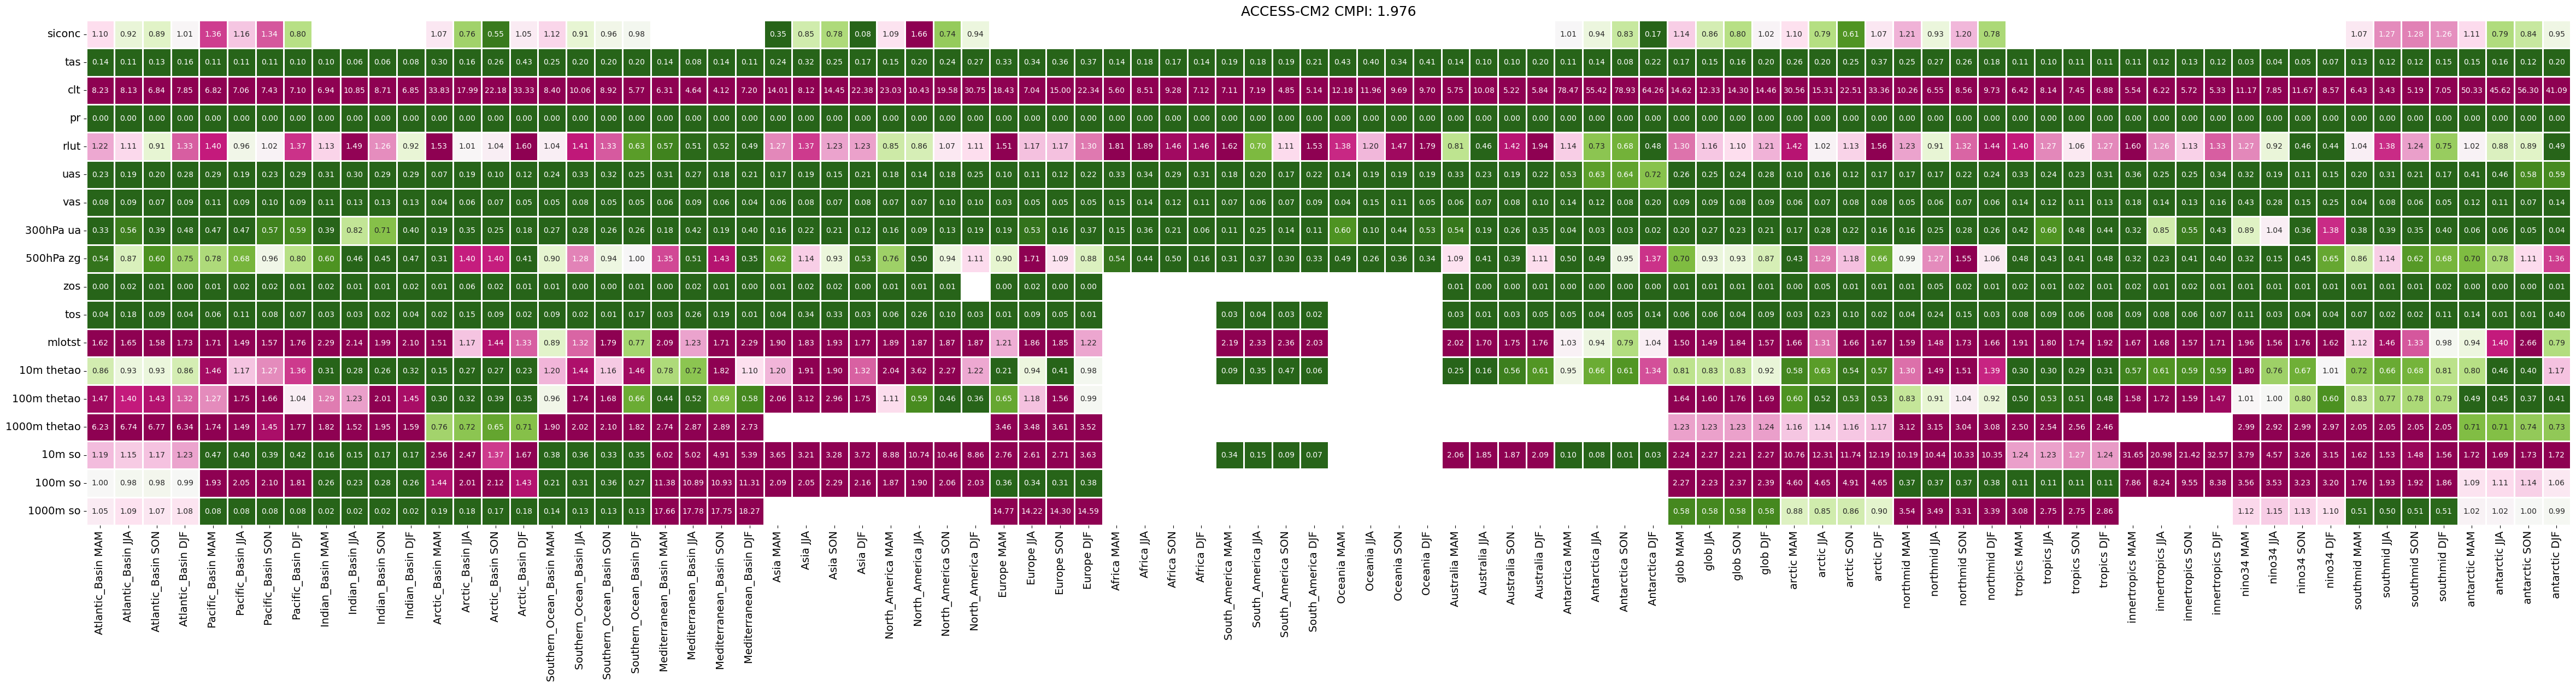

In [68]:
print('Reading precalculated evaluation field means of errors from csv files and plotting heatmap(s)')

# Make sure we loop often enough to catch the variables with the most number of levels/depths
max_depth=0
for var in obs:
    if len(var.depths) > max_depth:
        max_depth = len(var.depths)

plt.rcParams.update({'figure.max_open_warning': 0})
collect_frac_non = OrderedDict()
for model in tqdm(models):
    df = pd.read_csv(out_path+'frac/'+model.name+'_fraction.csv', delimiter=' ')
    values = df['FracMeanError'] #you can also use df['column_name']
    r=0
    for var in model.variables:
        a=(df['Variable']==var.name).to_list()
        if verbose == 'true':
            if any(a): # Check if variable appears in list. If not, skip it.
                print('reading: ',model.name,var.name)
            else:
                print('filling: ',model.name,var.name)
        for depth in var.depths:
            for region in regions:
                for seas in seasons:
                    if any(a):
                        collect_frac_non[var.name+' '+region,depth+' '+seas]=values[r]
                        r+=1
                    else:
                        collect_frac_non[var.name+' '+region,depth+' '+seas]=np.nan


    seasons_plot = [' MAM', ' JJA', ' SON', ' DJF'] #adding spaces in front
    a=seasons_plot*len(regions)
    b=np.repeat(list(regions.keys()),len(seasons_plot))
    coord=[n+str(m) for m,n in zip(a,b)]
    
    index_obs=[]
    for var in model.variables:
        for depth in var.depths:
            if depth == 'surface':
                levelname=''
            else:
                levelname=depth+' '
            if var == 'zos' or var == 'tos':
                levelname='st. dev. '
            index_obs.append(levelname+var.name)
    if verbose == 'true':
        print(model.name,'number of values: ',len(list(collect_frac_non.values())),'; shape:',len(index_obs),'x',len(regions)*len(seasons))
    collect_frac_reshaped = np.array(list(collect_frac_non.values()) ).reshape(len(index_obs),len(regions)*len(seasons)) # transform to 2D
    collect_frac_dataframe = pd.DataFrame(data=collect_frac_reshaped, index=index_obs, columns=coord)

    fig, ax = plt.subplots(figsize=((len(regions)*len(seasons))/1.5,len(index_obs)/1.5))
    fig.patch.set_facecolor('white')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = sns.heatmap(collect_frac_dataframe, vmin=0.5, vmax=1.5,center=1,annot=True,fmt='.2f',cmap="PiYG_r",cbar=False,linewidths=1)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(rotation=0, ha='right',fontsize=14)
    plt.title(model.name+' CMPI: '+str(round(cmpi[model.name],3)), fontsize=18)
    
    plt.savefig(out_path+'plot/'+model.name+'.png',dpi=300,bbox_inches='tight')
    i+=1


In [71]:
model.name

'AWI-CM1-MR'

  0%|                                                                                                                                                                                       | 0/30 [00:00<?, ?it/s]/p/project/chhb19/jstreffi/software/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:15<00:00,  4.50s/it]


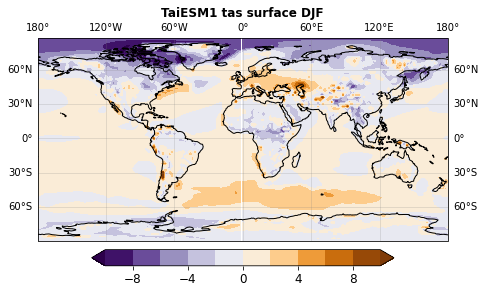

In [72]:
# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

for model in tqdm(models):
    for seas in seasons:
        depth=0
        levels=np.linspace(-10,10,11)
        #levels=np.linspace(-0,2000,11)
        var='clt'

        %matplotlib inline

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
        ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE,zorder=3)


        data = ds_model[var,depth,seas,model].to_array(var).values[0]
        obsp = np.squeeze(ds_obs[var,depth,seas].to_array(var).values[0])
        #data_to_plot = data[0:90,:]-obsp[0:90,:]
        data_to_plot = obsp[0:90,:]

        lon = np.arange(0, 360, 2)
        lat = np.arange(-90, 90, 2)

        imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

        ax.set_title(model+' '+var+' '+depth+' '+seas,fontweight="bold")
        plt.tight_layout() 
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

        gl.xlabels_bottom = False    
        cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
        cbar_ax_abs.tick_params(labelsize=12)
        cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
        cb.ax.tick_params(labelsize='12')
        plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')


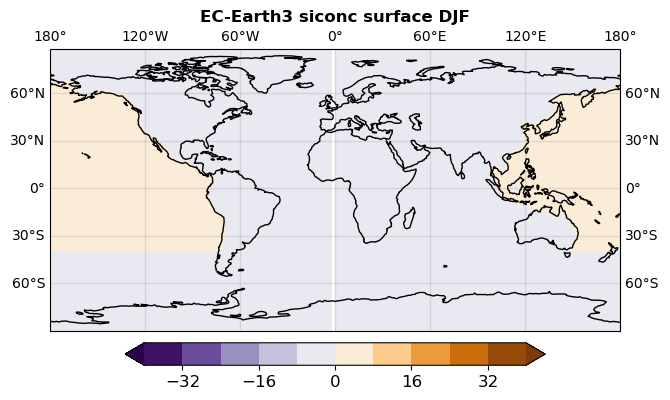

In [165]:



# Debug plot script


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import math

model="EC-Earth3"

for seas in seasons:
    depth=0
    levels=np.linspace(-40,40,11)
    #levels=np.linspace(-0,2000,11)
    var='siconc'

    %matplotlib inline

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4.5))
    ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE,zorder=3)


    #data = np.squeeze(regions['Africa']['mask'])
    data = masks[9,:,:]

    #data_to_plot = data[0:90,:]-obsp[0:90,:]
    data_to_plot = data[0:90,:]

    lon = np.arange(0, 360, 2)
    lat = np.arange(-90, 90, 2)

    imf=plt.contourf(lon, lat, data_to_plot, cmap=plt.cm.PuOr_r,levels=levels, extend='both', transform=ccrs.PlateCarree())

    ax.set_title(model+' '+var+' '+depth+' '+seas,fontweight="bold")
    plt.tight_layout() 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal')
    cb.ax.tick_params(labelsize='12')
    plt.savefig(out_path+'plot/maps/'+model+'_'+var+'_'+seas+'.png',dpi=200,bbox_inches='tight')

In [ ]:
Mask available for: 0 Asia
Mask available for: 1 North_America
Mask available for: 2 Europe
Mask available for: 3 Africa
Mask available for: 4 South_America
Mask available for: 5 Oceania
Mask available for: 6 Australia
Mask available for: 7 Antarctica
Mask available for: 0 Atlantic_Basin
Mask available for: 1 Pacific_Basin
Mask available for: 2 Indian_Basin
Mask available for: 3 Arctic_Basin
Mask available for: 4 Southern_Ocean_Basin
Mask available for: 5 Mediterranean_Basin
Mask available for: 14 glob
Mask available for: 15 arctic
Mask available for: 16 northmid
Mask available for: 17 tropics
Mask available for: 18 innertropics
Mask available for: 19 nino34
Mask available for: 20 southmid
Mask available for: 21 antarctic